# ML Report - cardiovascular disease
### Introduction
The following report is made to analyze and model machinlearning algorithms to classify cardiovascular diseases.  
THe report starts with a eda analysis on the data and is followed på hyperparameter optimization and lastly packaging for demonstration.  
The dataset used for the report is from kaggle and can be found here: [Link to Kaggle](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset)



In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# load dataset and a first view of the dataset
df = pd.read_csv("../data/cardio_train.csv", sep=";").drop(columns="id")
df["age"] = (df["age"]/365).astype(int) # Convert age from days to years

# Cleaning outliers and feature engineering
A BMI feature was added to data using following formula: 

BMI = $\frac{mass(kg)}{height(m)^2}$  

After creating of BMI-feature, cleaning data was necessary since there's alot of outliers.
While removing abnormal BMI values, limits for abnormality was set based on various BMI-charts online. BMIs above 70 and below 14 is extremely rare.
There may be real measures that's removed but if that's the case it only represents a very small part of the population. 

Cleaning of blood pressure values was necessary aswell, for both "ap_hi" and "ap_lo" the data includes many unreasonable values. To help with determination of the limits for what's "reasonable values", counsel with healthcare workers suggested the limits implemented.  
After cleaning outliers based on suggestion, the categorical bloodpressure feature ("BP_cat") was implemented.  
The categories for different blood pressure categories is taken from: [Bloodpressure range](https://www.healthline.com/health/high-blood-pressure-hypertension#definition)


In [47]:
from helpers import categorical_bmi, categorical_bloodpressure # importing help-functions
# Feature BMI
df["BMI"] = round(df["weight"] / (df["height"].astype(float)/100)**2, 1)

# Filtering outliers from BMI, ap_hi, ap_lo
idx_drop = []
idx_drop.append(df.query("BMI > 70 or BMI < 14").index) # BMI outliers
idx_drop.append(df.query("ap_hi < 80 | ap_hi > 200 | ap_lo < 40 | ap_lo > 110").index) # Blood pressure outliers
idx_drop = [i for sublist in idx_drop for i in sublist] # Flatten index 2d list to 1d list
df.drop(idx_drop, inplace=True) # drop outliers

# Creating categorical features for blood pressure and BMI
df["BP_cat"] = df.apply(categorical_bloodpressure, axis=1)
df["BMI_cat"] = df["BMI"].apply(categorical_bmi)


## Visual representation

A quick look at the data to show representations between gender, smokers and a few other features. The data is more represented by women than men, almost 2/3s of the datapoints is from women. A good thing noted is that the data is devided in 2 almost equal parts of people with and without cardio diseases. 


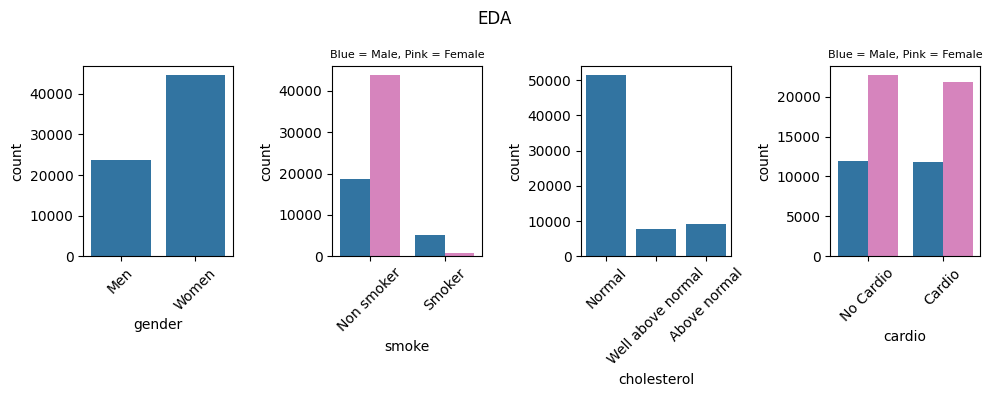

In [48]:
# EDA on dataset
from helpers import rename_columns

# Transform copy of df
df_copy = df.copy() 
df_renamed = rename_columns(df_copy)

# Setting up for plot variables for plots
cols_countplot = ["gender", "smoke", "cholesterol", "cardio"]
colors = sns.color_palette().as_hex()
blue, pink = colors[0], colors[6]

fig, axs = plt.subplots(nrows=1,ncols=len(cols_countplot), figsize=(10,4))
for i, col in enumerate(cols_countplot):
    if col in ["gender", "cholesterol"]:
        sns.countplot(ax=axs[i], x=df_renamed[col])
    else: 
        sns.countplot(ax=axs[i], x=df_renamed[col], hue=df_renamed["gender"], palette=[blue, pink], legend=None)
        axs[i].set_title("Blue = Male, Pink = Female", fontsize=8)
    axs[i].tick_params(axis="x", labelrotation=45)

fig.suptitle("EDA")
fig.tight_layout()

plt.savefig("../visualizations/g-s-ch-c_distribution.png")


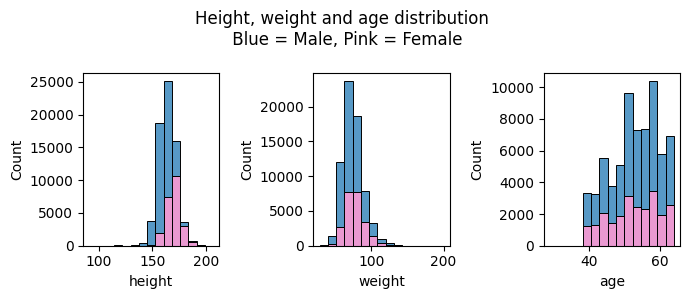

In [49]:
fig, axs = plt.subplots(1,3, figsize=(7,3))
cols_histplot = ["height", "weight", "age"]

for i, col in enumerate(cols_histplot):
    sns.histplot(ax=axs[i], data=df, x=col, hue="gender", palette=[blue,pink], bins=15, legend=None, multiple="stack")


fig.suptitle("Height, weight and age distribution \n Blue = Male, Pink = Female")
fig.tight_layout()

plt.savefig("../visualizations/h-w-a_distribution.png")

### Correlation Heatmap
A heatmap was made over the correlations between the numeric features of the data.  
The correlations shown in the heatmap was expected, for e.g. BMI and weight has a strong correlation, and the blood pressure measures -> "ap_hi" and "ap_lo" also shows high correlation between eachother, which ofcourse is expected aswell.  
The blood pressure measures also shows a correlation againts the cardio desease which is interesting. 
Other correlations that's expected is gender - height, which is well known. The correlation between "smoke - alco" was not a suprise, it implies that smoking and alcohol consumption is somewhat part of the same  lifestyle.

One interesting note taken is that alcohol and smoking does not seem to correlate with cardio desease at all.


<Axes: >

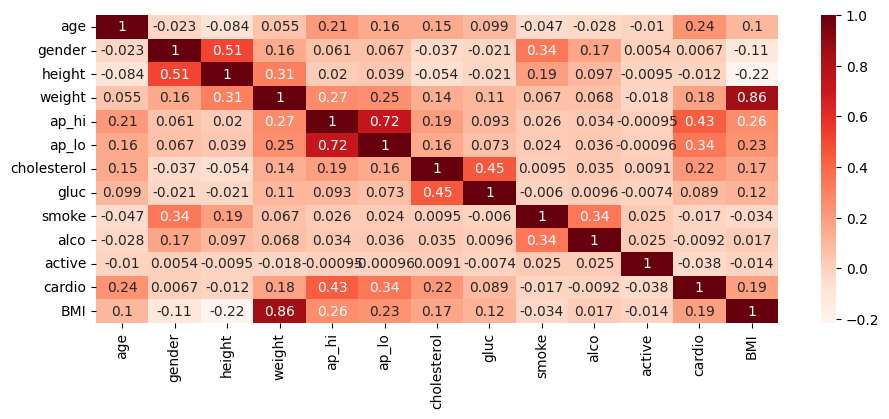

In [50]:
plt.figure(figsize=(11,4))
sns.heatmap(df.corr(numeric_only=True), cmap="Reds", annot=True)

## Evaluating machinelearning algorithms

To help with the choice of algorithm and hyperparameters to use to try and predict cardiovascular diseases, a nested loop is created. First loop selects dataframe and the second one is iterating different algorithms using pipelines, to help and decide what algorithm and hyperparameters that works best for predictions on the data. 

The results for every algorithm tested can be examined by a ConfusionMatrix plot that was saved in folder: *"/Laboration/visualizations/CM"*. The classification report with the best parameters is also saved and can be viewed in text [here](/Laboration/results/result.txt). 

The results show that the predictions have a higher accuracy with the dataset that has no categorical data. (df2)  
It also shows that the "SVC(C=1, gamma=0.1)" setup was the overall best predictor for the data.  
But, if we compare the SVC model with the Random Forest classifier we note that the forest classifier has little higher accuracy on predicting that the patient has no disease.  
And in this case, when it comes to predicting diseases it's better to wrongly predict "disease" while the patient actually wasn't sick than the other way around.  
There are worse consequenses if the model predicts "no disease" while the patient actually turns out to be sick.  

With this conclusion in mind, the RandomForestClassifier with n_neighbors = 180, on the dataset without categorical features (df2) is the best predictor for this data.

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

scaler = StandardScaler()

# Preparing different dataframes for training and testing
df1 = df.drop(columns=["ap_hi", "ap_lo", "height", "weight", "BMI"], axis="columns") # df with categorical features
df2 = df.drop(columns=["BMI_cat", "BP_cat", "height", "weight"], axis="columns") # df without categorical features
df1 = pd.get_dummies(data=df1, columns=["BMI_cat", "BP_cat", "gender"], drop_first=True)
df2 = pd.get_dummies(data=df2, columns=["gender"], drop_first=True)

dfs = {"Categorical data": df1, 
       "Non Categorical data" : df2}

Starting tuning with dataframe: Categorical data

Starting training for KNneighbors
KNneighbors done!

Starting training for Logistical Regression
Logistical Regression done!

Starting training for Random Forest
Random Forest done!

Starting training for SVC
SVC done!

Starting tuning with dataframe: Non Categorical data

Starting training for KNneighbors
KNneighbors done!

Starting training for Logistical Regression
Logistical Regression done!

Starting training for Random Forest
Random Forest done!

Starting training for SVC
SVC done!



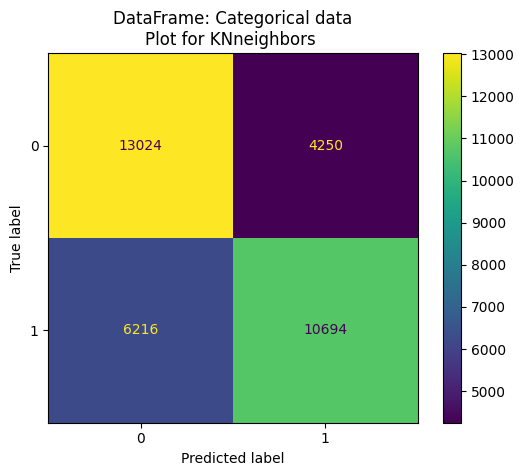

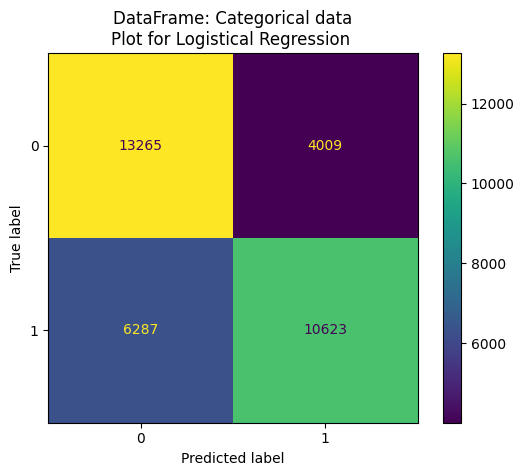

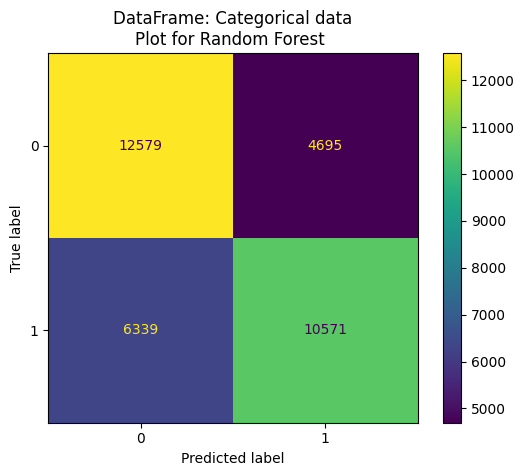

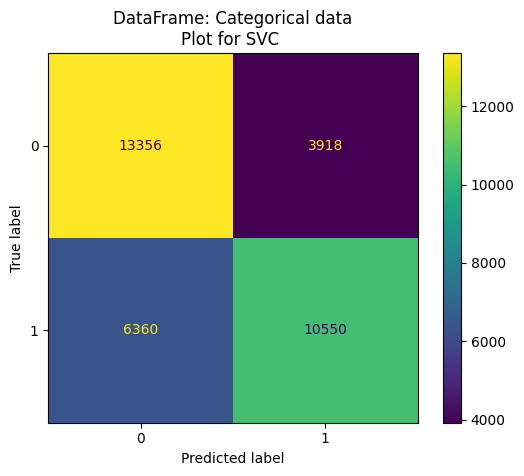

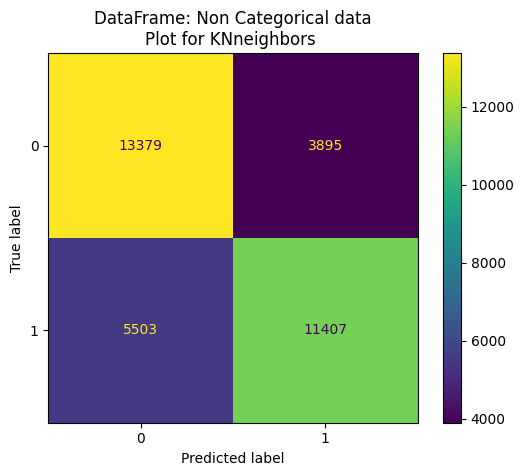

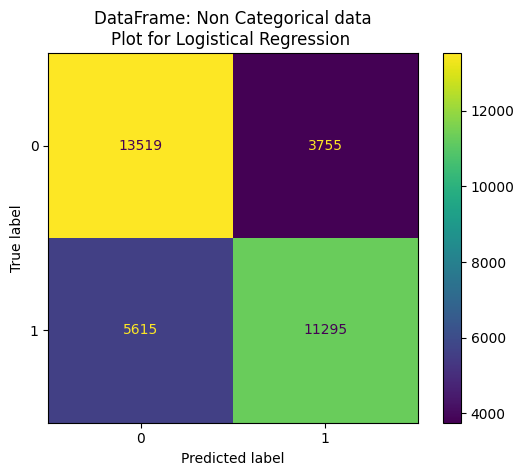

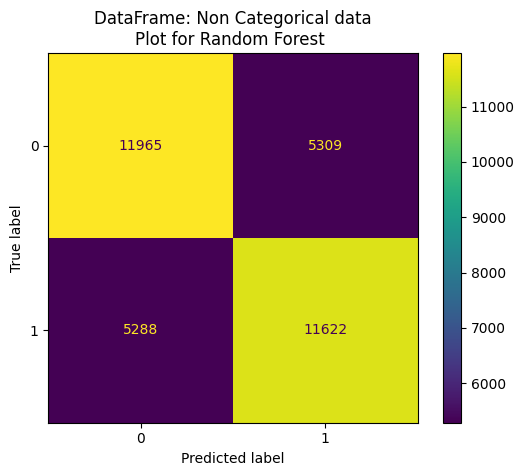

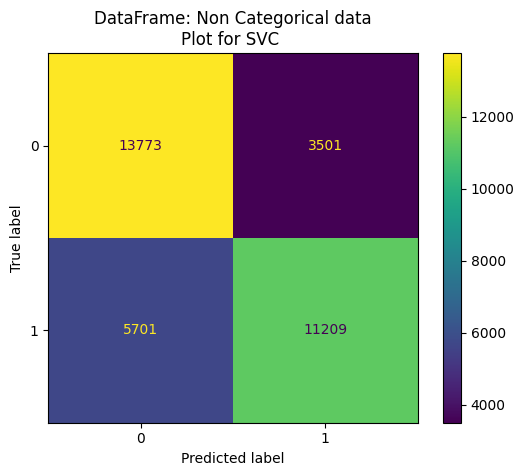

In [52]:
# Setting up pipelines
pipe_knn = Pipeline([("scaler", scaler), ("knn", KNeighborsClassifier())])
pipe_log = Pipeline([("scaler", scaler), ("log", LogisticRegression(max_iter=10000, penalty="elasticnet", solver="saga"))])
pipe_forest = Pipeline([("forest", RandomForestClassifier())])
pipe_svc = Pipeline([("scaler", scaler), ("svc", SVC())])

# Setting upp parameter grid for pipelines
params_knn =  {"knn__n_neighbors": list(range(1,50))}
params_log = {"log__l1_ratio": np.linspace(0, 1, 20), "log__C" : [1.0, 1.2]}
params_forest = {"forest__n_estimators": list(range(50,200,10))}
params_svc = {"svc__C": [0.1, 1], "svc__gamma": [1, 0.1], "svc__kernel": ["rbf"]}

classifiers = ["KNneighbors", "Logistical Regression", "Random Forest", "SVC"]
pipes = [pipe_knn, pipe_log, pipe_forest, pipe_svc]
params = [params_knn, params_log, params_forest, params_svc]

# Clear file content of result.txt
with open("../results/result.txt", "w") as f: 
    f.close()

# Loop through the 2 datasets to be tested
for df_label, data in dfs.items(): 
    print(f"Starting tuning with dataframe: {df_label}\n")
    X, y = data.drop(columns="cardio", axis="columns"), data["cardio"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=56)

    # For every dataset, optimize, train and evaluate the different algorithms to be tested
    for classifier, pipe, param_grid in zip(classifiers, pipes, params): 

        print(f"Starting training for {classifier}")

        clsf = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring="accuracy")

        # Train model and create classification reports
        clsf.fit(X_train, y_train)
        y_pred= clsf.predict(X_test)
        cr = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        # Create and save ConfusionMatrix to folder
        ConfusionMatrixDisplay(cm).plot()
        plt.title(f"DataFrame: {df_label}\nPlot for {classifier} ")
        plt.savefig(f"../visualizations/CM/{classifier}-{df_label}_cm.png")
        
        # Write results to result.txt
        with open("../results/result.txt", "a") as f:
            f.write(f"Best parameters for {classifier}-{df_label}:\n {str(clsf.best_estimator_.get_params())}\n")
            f.write(f"{cr}\n\n")

        
        print(f"{classifier} done!\n")

        


## Packaging

Export of the model for production testing.  
THe algorithm chosen based on previous testing and results: RandomForestClassifier with 150 n_estimators.

In [53]:
import joblib

df_export =  df2.sample(100, random_state=56)
df_export.to_csv("../data/test_samples.csv", index=False)
df2.drop(df_export.index, inplace=True)

X, y = df2.drop(columns= "cardio", axis="columns"), df2["cardio"]
# Fit best model and save for production

model = RandomForestClassifier(n_estimators=150)
model.fit(X, y)

joblib.dump(value=model, filename="../production/model.pkl", compress=True )

['../production/model.pkl']